In [1]:
#Importing necessary libraries
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers
from keras import backend as K
import keras

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import string
plt.rc('text', usetex=False)

import pickle

from Autoencoder_Utils import *


/usr/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:

TYPE = ""
TYPE = "_10perc"
TYPE = "_1perc"


df = pd.read_csv('Data/Df_example{}.csv'.format(TYPE))


var_list = list(df)


print df['pid'].value_counts()
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

f    4560
a    4464
e    4405
c    4175
d    3703
b    3570
Name: pid, dtype: int64


In [3]:
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], [] 
for v in vars_list:
    if v=='pid': vars_list_MC.append(v)
    elif 'aux' in v: vars_list_aux.append(v)
    else: vars_list_input.append(v)
print "{} variables to compress".format(len(vars_list_input)) 

18 variables to compress


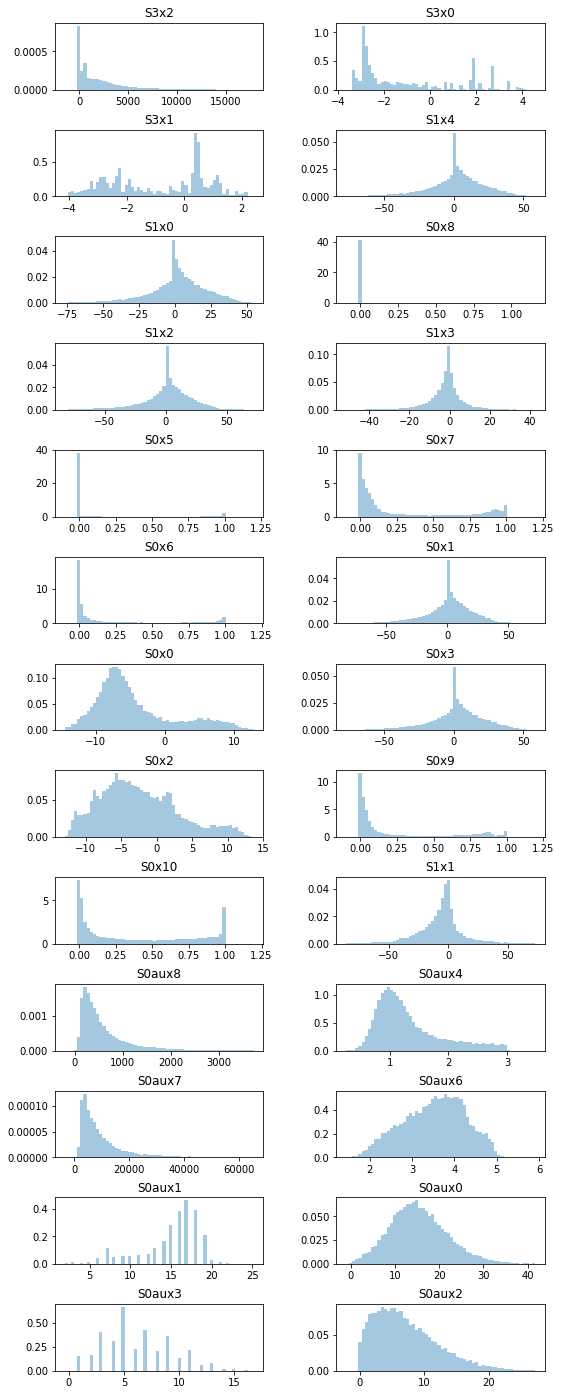

In [4]:
print_features_histograms(df[vars_list_input+vars_list_aux], None, save_filename="original_distribs.png")

 S C A L E D --- D F 


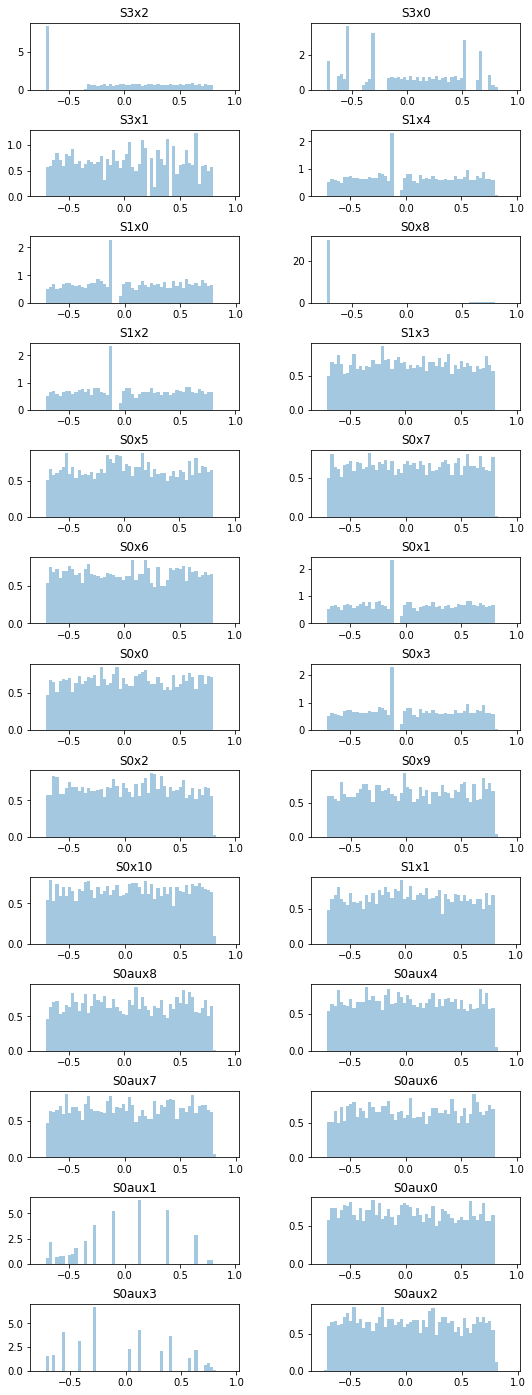

In [5]:
##############################
#####   S C A L I N G  #######
##############################

SCALING           = True
SCALE_BY_CORR_PID = False


if SCALING:
    if SCALE_BY_CORR_PID:
        # Mike suggested that the ProbNN-mu variable is only scaled by the distribution of 
        # ProbNNmu for the corresponding particle (muon).
        # This way the mean squared error for low values of ProbNNmu doesn't matter as much. 

        
        #THis is not implemented for AUX variables, yet
        scaling_ar = np.zeros((pids_no[fig_to_corr_pid[0]]  ,1))

        for i_pid, pid in enumerate(fig_to_corr_pid):
            scaling_ar_temp = df.loc[df['pid'] == pid][[var_list[i_pid+1]]]
            #scaling_ar_temp = df[[var_list[i_pid]]]
            scaling_ar_temp = scaling_ar_temp.values
            #print type(scaling_df_temp)
            #print scaling_df_temp
            scaling_ar = np.c_[scaling_ar,scaling_ar_temp]
        #print scaling_ar
        scaling_df = pd.DataFrame(scaling_ar, columns=df.columns)
        
        print " S C A L I N G --- D F "
        print_features_histograms(df, scaling_df, save_filename="unscaled_distribs.png", normed=False)
        
        print "--"*100


    data_MC    = df[vars_list_MC].copy().values
    data_input = df[vars_list_input].copy().values
    data_aux   = df[vars_list_aux].copy().values
    

    #Scaling, so that output is gaussian. I wrote this package
    import FunctionScaler
    #fs = FunctionScaler.FunctionScaler("unif")  # calling the uniform function by name
    #fs = FunctionScaler.FunctionScaler("gauss-11", downplay_outofbounds="both") # calling the normal function by name
    #fs = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Gauss(0,1./6.), downplay_outofbounds_lower_n_range=1., downplay_outofbounds_upper_n_range=1., downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
    #fs = FunctionScaler.FunctionScaler("gauss-11", downplay_outofbounds_lower_n_range=1., downplay_outofbounds_upper_n_range=1., downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
    fs = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-0.7,.8), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
    fs_aux = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-0.7,.8), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name

    
    
    
    if SCALE_BY_CORR_PID: 
        fs.fit(scaling_df.values[:,1:])
    else                : 
        #fs.fit(df.values[:,1:])
        if"prec" in TYPE:
            fs.fit(data_input)
            fs_aux.fit(data_aux)
        else:
            fs.fit(data_input[:(len(data_input)/10), :]) #Train the transform on 10% of the data
            fs_aux.fit(data_aux[:(len(data_aux)/10), :]) #Train the transform on 10% of the data
        
    scaled_data_input = fs.transform(data_input)
    scaled_data_aux = fs_aux.transform(data_aux)
    #scaled_features = fs.transform(df.values[:,1:])
    if SCALE_BY_CORR_PID: 
        scaled_scaling_features = fs.transform(scaling_df.values[:,1:])
        scaled_scaling_features = np.c_[scaling_df.values[:,0],scaled_scaling_features]
        scaled_scaling_features_df = pd.DataFrame(scaled_scaling_features, columns=scaling_df.columns)
    #scaled_features = fs.fit_transform(df.values[:,1:])
    scaled_features = np.c_[data_MC,scaled_data_input, scaled_data_aux]
    scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=vars_list_MC+vars_list_input+vars_list_aux)
    scaled_features_df.head()
    
    
    
    
    print " S C A L E D --- D F "
    
    #print_features_histograms(scaled_features_df, None, save_filename="scaled_distribs.png")
    #print_features_histograms(scaled_scaling_features_df, None, save_filename="scaled_distribs.png")
    if SCALE_BY_CORR_PID:
        print_features_histograms(scaled_features_df[vars_list_input+vars_list_aux],scaled_scaling_features_df[vars_list_input+vars_list_aux], save_filename="scaled_distribs.png", normed=False)
    else:
        print_features_histograms(scaled_features_df[vars_list_input+vars_list_aux], None, save_filename="scaled_distribs.png", normed=True)
    
    df= scaled_features_df 
    


In [6]:
# this is the size of our encoded representations
training_frac = 0.70
val_frac      = 0.20


n_train = int(n_samples*training_frac)
n_val = int(n_samples*val_frac) 
n_test = int(n_samples*(1-training_frac-val_frac))

print ("Nb train exmaples " + str(n_train) )
print ("Nb val exmaples " + str(n_val) )
print ("Nb test exmaples " + str(n_test) )

Nb train exmaples 17413
Nb val exmaples 4975
Nb test exmaples 2487


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(22389, 18) (22389, 8) (22389, 1)
(2488, 18) (2488, 8) (2488, 1)
encoding_dim :  1
Epoch 00022: early stopping
2488/2488 [==============================] - 0s 15us/step



encoding_dim :  3
Epoch 00035: early stopping
2488/2488 [==============================] - 0s 16us/step



encoding_dim :  6
Epoch 00041: early stopping
2488/2488 [==============================] - 0s 17us/step



encoding_dim :  9
Epoch 00043: early stopping
2488/2488 [==============================] - 0s 17us/step



encoding_dim :  12
Epoch 00031: early stopping
2488/2488 [==============================] - 0s 17us/step



encoding_dim :  15
Epoch 00039: early stopping
2488/2488 [==============================] - 0s 19us/step



encoding_dim :  18
Epoch 00023: early stopping
2488/2488 [==============================] - 0s 20us/step





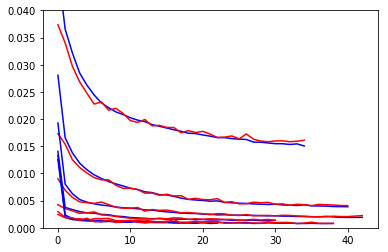

In [7]:
#l_encoding_dim = [1,2,3,4,5,6,7,8,9,10,11,12]
#l_encoding_dim = [1,2,3,4,5,6,7,8,9]
#l_encoding_dim = [1,3,5,8,11,14,18]

l_encoding_dim = [1,3,6,9,12,15,18]

#l_encoding_dim = [3]

if "dummy" in TYPE: l_encoding_dim = [9]
#l_encoding_dim = [8]
l_score = []

#n_layers = 3; thickness =2 #Unopt
n_layers = 4; thickness =6 #opt


name_arch = "{}h_nodrop_aux".format(n_layers)
train, test = train_test_split(df, random_state=42,train_size=training_frac+val_frac)


        
train_input = train[vars_list_input].copy().values
train_aux   = train[vars_list_aux].copy().values
train_MC    = train[vars_list_MC].copy().values

test_input = test[vars_list_input].copy().values
test_aux   = test[vars_list_aux].copy().values
test_MC    = test[vars_list_MC].copy().values


if train_aux.shape[1]==0: 
    train_aux = np.ones((train_input.shape[0], 2))
    
if test_aux.shape[1]==0: 
    test_aux = np.ones((test_input.shape[0], 2))
    
print train_input.shape, train_aux.shape, train_MC.shape
print test_input.shape, test_aux.shape, test_MC.shape


nb_epoch = 50
batch_size = 50


early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=3, mode='min')
#tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}
    
for encoding_dim in l_encoding_dim:
    print "encoding_dim : ", encoding_dim

    autoencoder, encoder, decoder = create_autoencoder_aux(train_input.shape[1], encoding_dim, n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness)

    history = autoencoder.fit([train_input, train_aux], train_input,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=0,
                    validation_split=val_frac/(training_frac+val_frac),
                    callbacks =[early_stopping]
                    )

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    #print "\n\nscore : ", score
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder([encoded_test, test_aux, 0])[0] #test mode = 0
    #print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test
    save_encoded_dict[encoding_dim] = encoded_test

    #plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
    #plt.xlim(0, 40)
    print "\n\n"




In [8]:
retain_dict = {}
retain_dict['save_decoded_dict']= save_decoded_dict
retain_dict['save_encoded_dict'] =save_encoded_dict
retain_dict['test_input']= test_input
retain_dict['test_aux'] = test_aux
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score


In [9]:
if False:
    #For some reason not working here. Works for unobscured dataset
    retain_dict['test_input_dec'] = fs.invtransform(test_input)
    retain_dict['test_aux_dec'] = fs_aux.invtransform(test_aux)

    save_decoded_dict_dec = {}
    for encoding_dim in save_decoded_dict:
        save_decoded_dict_dec[encoding_dim] = fs.invtransform(save_decoded_dict[encoding_dim])

    retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [10]:
pickle.dump( retain_dict, open( "retain_dict_{}.p".format(TYPE), "wb" ) )

In [11]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False)